In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 1000
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

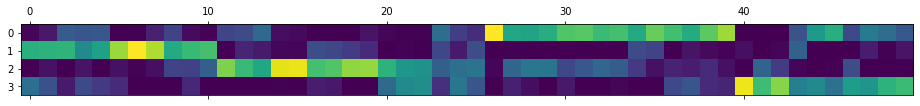

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(50, 1000, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': array([3.]), 'allele_prior_alpha': array([1.]), 'allele_prior_beta': array([1.])}


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (1000, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                            use_logitnormal_sticks=use_logitnormal_sticks,
                                            seed = 143241)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict['ind_mix_stick_propn_mean'], 
                            vb_params_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

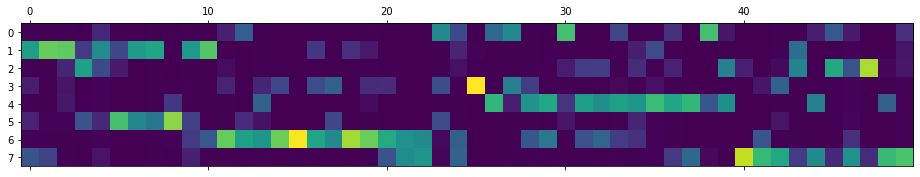

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

In [15]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            use_logitnormal_sticks,
                            gh_loc, gh_weights)

173998.32023112092

# Run CAVI

In [15]:
t0 = time.time()

vb_opt_dict, vb_opt, ez_opt, _, _ = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        use_logitnormal_sticks,
                        gh_loc = gh_loc, gh_weights = gh_weights, 
                        max_iter = 1000,
                        x_tol = 1e-4, 
                        print_every = 20)

print('elapsed: ')
print(time.time() - t0)

iteration [20]; kl:7634.979047; elapsed: 0.6165secs
iteration [40]; kl:7587.289418; elapsed: 0.5427secs
iteration [60]; kl:7570.268271; elapsed: 0.7275secs
iteration [80]; kl:7562.300266; elapsed: 0.8397secs
iteration [100]; kl:7555.715689; elapsed: 0.6277secs
iteration [120]; kl:7547.295474; elapsed: 0.6199secs
iteration [140]; kl:7536.391418; elapsed: 0.6889secs
iteration [160]; kl:7521.934175; elapsed: 0.6768secs
iteration [180]; kl:7506.312987; elapsed: 0.6712secs
iteration [200]; kl:7492.980252; elapsed: 0.6957secs
iteration [220]; kl:7488.117376; elapsed: 0.5041secs
iteration [240]; kl:7484.594707; elapsed: 0.5536secs
iteration [260]; kl:7481.460106; elapsed: 0.4954secs
iteration [280]; kl:7480.232761; elapsed: 0.5376secs
iteration [300]; kl:7479.175408; elapsed: 0.5288secs
iteration [320]; kl:7478.126562; elapsed: 0.4332secs
iteration [340]; kl:7477.038055; elapsed: 0.4864secs
iteration [360]; kl:7475.661068; elapsed: 0.4689secs
iteration [380]; kl:7473.187981; elapsed: 0.4896se

In [16]:
(vb_opt**2).mean()

4.63718136862826

In [17]:
(ez_opt**2).mean()

0.08734638244030406

In [18]:
vb_opt_dict = vb_params_dict
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [19]:
# structure_model_lib.assert_optimizer(g_obs, vb_opt_dict, vb_params_paragami,
#                         prior_params_dict, gh_loc, gh_weights,
#                         use_logitnormal_sticks)


# Define objective

In [21]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, 
                                    use_logitnormal_sticks = use_logitnormal_sticks,
                                    gh_loc = gh_loc,
                                    gh_weights = gh_weights)

In [22]:
def get_jac_hvp_fun(f):
    def hvp(x, v):
        return jax.jvp(jax.grad(f), (x, ), (v, ))[1]
    return hvp

In [23]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum = 0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum = 0)
obj_fun_hvp = autograd.hessian_vector_product(lambda x : objective_fun(x, prior_params_free))


# Derivative times

In [24]:
# function time
%timeit objective_fun(vb_opt, prior_params_free)

7.84 ms ± 745 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
# gradient time
%timeit obj_fun_grad(vb_opt, prior_params_free)

27.7 ms ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
# if its impossible, don't run the hessian
run_hessian = False

In [27]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

In [28]:
# cross hessian 
hyper_obj_fun_grad = autograd.jacobian(objective_fun, argnum=1)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=0)

cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free).transpose()

In [29]:
%timeit hyper_obj_cross_hess(vb_opt, prior_params_free)

16.9 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit obj_fun_hvp(vb_opt, cross_hess[:, 0])

69.9 ms ± 6.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Solver times

In [31]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))
    

In [32]:
import vittles

In [33]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
_ = -cg_solver(cross_hess[:, 0])
print('solver compile time: {:0.3}sec'.format(time.time() - t0))

solver compile time: 6.09sec


In [34]:
# it seems like something is getting compiled, but 
# not sure what. Second time is faster
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 5.22sec


In [35]:
t0 = time.time()
mfvb_preconditioner = \
    get_mfvb_cov(vb_opt_dict, vb_params_paragami, use_logitnormal_sticks, return_info = True)

print('preconditioner time: {:0.3}sec'.format(time.time() - t0))

preconditioner time: 0.375sec


In [36]:
cg_solver_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, x), 
                                            dim = len(vb_opt), 
                                            cg_opts = {'M': mfvb_preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))



preconditioned solver time: 2.84sec


In [37]:
if run_hessian: 
    print(np.abs(dinput_dhyper[:, 0] - dinput_dhyper2).max())
    
print(np.abs(dinput_dhyper3 - dinput_dhyper2).max())

0.0001743236063441178


In [38]:
(dinput_dhyper2**2).mean()

0.8284326189941326